# MLP Classifier

### Imports

In [2]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

### Create Dataset Object

In [3]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

### Define Model Architecture

In [4]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        # Define the first hidden layer
        self.hidden1 = nn.Linear(17, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3) 
        
        # Define the second hidden layer
        self.hidden2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # Define the third layer
        self.hidden3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        
        # Define the fourth layer
        self.hidden4 = nn.Linear(32, 16)
        self.batch_norm4 = nn.BatchNorm1d(16)
        self.relu4 = nn.ReLU()
        
        # Define the output layer
        self.output = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.dropout1(self.relu1(self.batch_norm1(self.hidden1(x))))
        x = self.dropout2(self.relu2(self.batch_norm2(self.hidden2(x))))
        x = self.dropout3(self.relu3(self.batch_norm3(self.hidden3(x))))
        x = self.relu4(self.batch_norm4(self.hidden4(x)))
        x = self.sigmoid(self.output(x))
        return x


### Load and Clean Data 

In [5]:
# Load the data
df = pd.read_csv('../Data/dataset83.csv')
df.drop(['Year_start', 'Year_end'], axis='columns', inplace=True)

# Convert categorical columns to numeric labels
label_encoder = LabelEncoder()
df['Species'] = label_encoder.fit_transform(df['Species'])
df['Population'] = label_encoder.fit_transform(df['Population'])
df['Sex'] = label_encoder.fit_transform(df['Sex'])

# Converting a column to float
df['Thorax_length'] = pd.to_numeric(df['Thorax_length'], errors='coerce').astype('float64')

# Converting a column to int (after ensuring it's first converted to float to handle non-integer formats)
df['wing_loading'] = pd.to_numeric(df['wing_loading'], errors='coerce').astype('float64')

# Fill in missing values 
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        # Fill missing values with mean for numerical columns
        col_mean = df[col].mean()
        df[col] = df[col].fillna(col_mean)
    elif df[col].dtype == 'object':
        # Fill missing values with mode for categorical columns
        col_mode = df[col].mode()[0]
        df[col] = df[col].fillna(col_mode)

### Seperate Labels/Features and Normalise/Scale

In [6]:
# Separate features and target label
X = df.drop('Sex', axis=1)
y = df['Sex']

# Normalize and scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_scaled = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.int64)

### Split Data into Train and Test

In [7]:
# Split data into train+val and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=69, stratify=y) # We use stratify in order to ensure good classes are split evenly for classification

### Define Training

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            predicted = outputs.round()
            train_correct += (predicted.squeeze() == labels).sum().item()
            train_total += labels.size(0)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_correct / train_total)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                predicted = outputs.round()
                val_correct += (predicted.squeeze() == labels).sum().item()
                val_total += labels.size(0)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_correct/train_total:.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_correct/val_total:.4f}')

        # Step the scheduler
        scheduler.step()
        
    return train_losses, train_accuracies, val_losses, val_accuracies


### Perform 10 Fold CV Training 

In [9]:
# Define KFold
kf = KFold(n_splits=10, shuffle=True, random_state=69)

# Define batch size and criterion
batch_size = 32
criterion = nn.BCELoss()

# Placeholder for the best model's performance and state
best_model_wts = None
best_accuracy = 0

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val)):
    print(f"Training fold {fold+1}/10")
    
    # Create datasets for the current fold
    train_dataset = CustomDataset(X_train_val[train_idx], y_train_val[train_idx])
    val_dataset = CustomDataset(X_train_val[val_idx], y_train_val[val_idx])
    
    # Data loaders for the current fold
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model and optimizer
    model = BinaryClassifier()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    # Train the model
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100
    )
    
    # Check if the current model is the best one
    current_val_accuracy = max(val_accuracies)
    if current_val_accuracy > best_accuracy:
        best_accuracy = current_val_accuracy
        best_model_wts = model.state_dict()  # Save the best model weights
        best_train_losses = train_losses
        best_val_losses = val_losses
        best_train_accuracies = train_accuracies
        best_val_accuracies = val_accuracies

# Load the best model weights
model.load_state_dict(best_model_wts)

Training fold 1/10
Epoch 1/100 - Loss: 0.6115, Accuracy: 0.6867, Val Loss: 0.5217, Val Accuracy: 0.8782
Epoch 2/100 - Loss: 0.4540, Accuracy: 0.8687, Val Loss: 0.3935, Val Accuracy: 0.9167
Epoch 3/100 - Loss: 0.3534, Accuracy: 0.9072, Val Loss: 0.3396, Val Accuracy: 0.9167
Epoch 4/100 - Loss: 0.2796, Accuracy: 0.9222, Val Loss: 0.2887, Val Accuracy: 0.9231
Epoch 5/100 - Loss: 0.2308, Accuracy: 0.9358, Val Loss: 0.2770, Val Accuracy: 0.9359
Epoch 6/100 - Loss: 0.2192, Accuracy: 0.9272, Val Loss: 0.2595, Val Accuracy: 0.9295
Epoch 7/100 - Loss: 0.1931, Accuracy: 0.9350, Val Loss: 0.2580, Val Accuracy: 0.9359
Epoch 8/100 - Loss: 0.1767, Accuracy: 0.9336, Val Loss: 0.2669, Val Accuracy: 0.9295
Epoch 9/100 - Loss: 0.1865, Accuracy: 0.9315, Val Loss: 0.8619, Val Accuracy: 0.9295
Epoch 10/100 - Loss: 0.1732, Accuracy: 0.9365, Val Loss: 0.2525, Val Accuracy: 0.9295
Epoch 11/100 - Loss: 0.1593, Accuracy: 0.9415, Val Loss: 0.8588, Val Accuracy: 0.9231
Epoch 12/100 - Loss: 0.1650, Accuracy: 0.944

<All keys matched successfully>

### Plot Results of Best Model

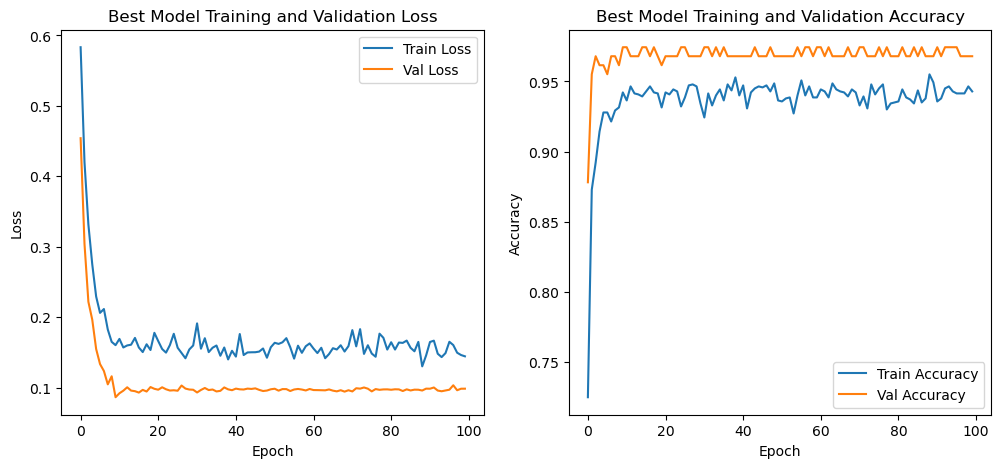

In [10]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Val Loss')
plt.title('Best Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(best_train_accuracies, label='Train Accuracy')
plt.plot(best_val_accuracies, label='Val Accuracy')
plt.title('Best Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Evaluate Best Model

In [11]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            predicted = outputs.round()
            test_correct += (predicted.squeeze() == labels).sum().item()
            test_total += labels.size(0)
            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_correct/test_total:.4f}')

# Evaluate the best model on the test set
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
evaluate(model, test_loader, criterion)


Test Loss: 0.1016, Test Accuracy: 0.9598
